In [1]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
# from fitter import Fitter, get_common_distributions, get_distributions
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.make_holidays import *
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.utilities import regressor_coefficients
from prophet.utilities import regressor_index
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tsa.stattools import adfuller
import cmdstanpy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import dask
import logging

#### Deta Prep
1. Converting the date column from the csv to datetime is necessary for Prophet to run.
2. The date columns must be in 2023-12-31 format.
3. The revenue column should be renamed to 'y' and the date column should be renamed to 'ds'.
4. Forecast works well with simply the date and revenue, but more variables can be added.

In [2]:
df = pd.read_csv('C:/Users/norri/Desktop/tyson_formatted.csv')
df['ds'] = pd.to_datetime(df['ds'])
df.sort_values(by=['loc', 'ds'], inplace=True)
df['promos'] = np.where(df['promos'] > 0, 1, df['promos'])
df.sort_values(by=['loc', 'ds'], inplace=True)

In [3]:
locations = df.groupby('loc')['promos'].sum()
locations = locations[locations == locations.max()]

In [4]:
print(locations)


loc
1579149    3
1579159    3
1579160    3
1579164    3
1579184    3
1579185    3
1579199    3
1579204    3
1579207    3
1579213    3
1579215    3
1579216    3
1579224    3
1579239    3
1579244    3
1579257    3
1579259    3
1579262    3
1579273    3
1579287    3
1579289    3
1579294    3
1579303    3
1579307    3
1579328    3
1579329    3
1579334    3
1579377    3
1579388    3
1579389    3
1579393    3
1579405    3
Name: promos, dtype: int64


In [5]:
df = df[df['loc'] == 1579328]

In [6]:
# df1 = df[df['promos'] > 0]
# df1.sort_values(by=['loc', 'ds'], inplace=True)
# df1['promos'] = df1['promos'].apply(lambda x: 1)

In [7]:
# df2 = df.merge(df1, how='left', on=['loc', 'ds'])
# df2.sort_values(by=['loc', 'ds'], inplace=True)

In [8]:
# df2 = df2.fillna(0)

In [9]:
# df_regressors = df[['ds', 'promos']]
df.drop(['loc'], axis=1, inplace=True)

## Prophet Setup

??Check to see if these are the right splits??

In [10]:
# df1 = df[df['ds'] >= '2024-04-30']
# df = df[df['ds'] < '2024-04-30']
m = Prophet()
m.fit(df)

15:07:45 - cmdstanpy - INFO - Chain [1] start processing
15:07:45 - cmdstanpy - INFO - Chain [1] done processing


Page 2 should determine periods

Since there are many locations over the same period of time, makefuture creates future dates but aggregates observations somehow

In [11]:
future = m.make_future_dataframe(periods=30)

In [12]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
588,2024-06-26,32.564312,-0.309449,68.379806
589,2024-06-27,31.880890,-0.460033,65.388864
590,2024-06-28,32.522864,0.414950,66.558200
591,2024-06-29,41.174246,7.036530,72.428980
592,2024-06-30,61.163604,28.505910,95.060682


White dots are observations, blue is the trendline, with future error beyond, can check the dots to see method of aggregation

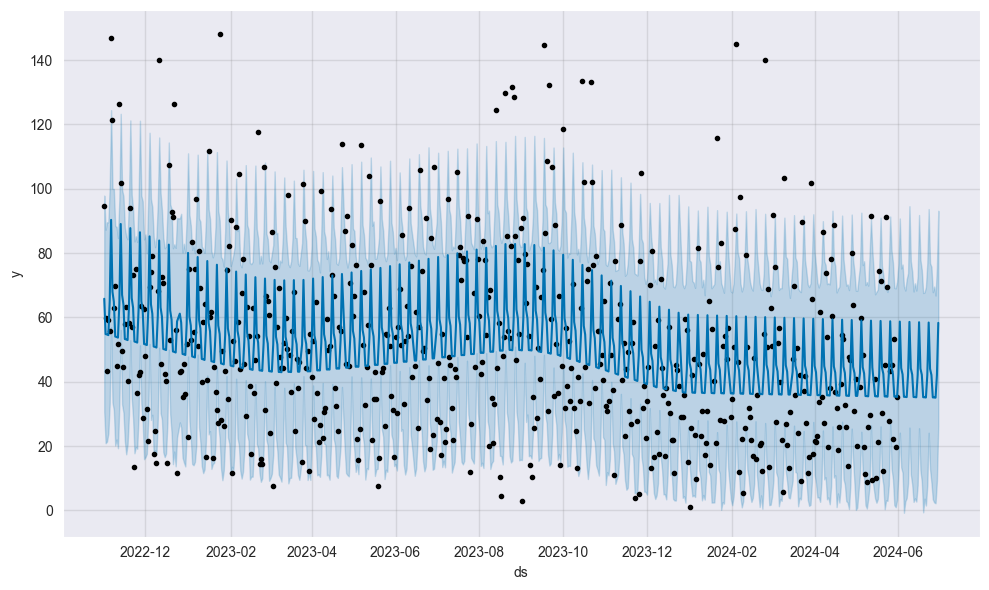

In [60]:
fig1 = m.plot(forecast)

Trend seems fairly consistent, but the weekly shows an uplift at the weekend, so necessary correction

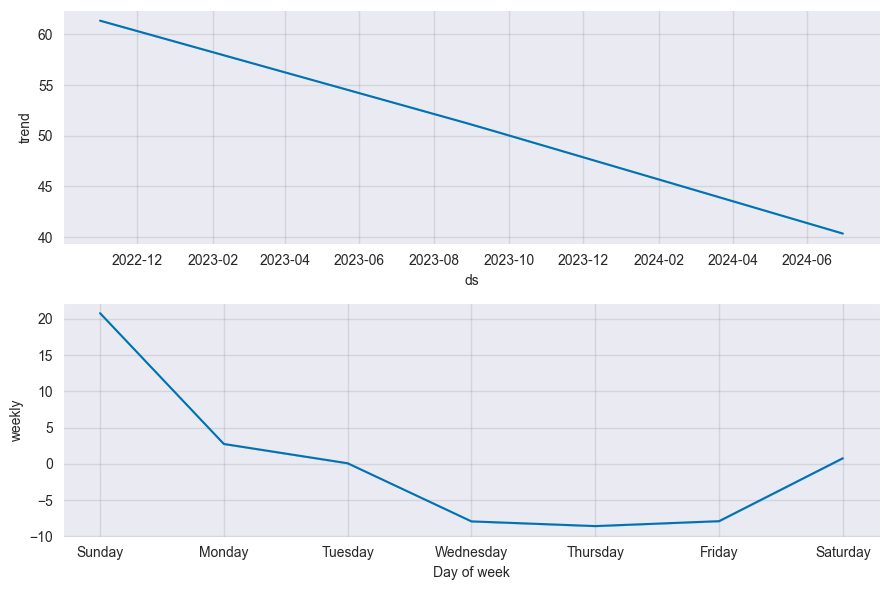

In [14]:
fig2 = m.plot_components(forecast)

In [15]:
# plot_plotly(m, forecast)

In [16]:
# plot_components_plotly(m, forecast)

Details about options for methods are available in docstrings and help(Prophet)

### Forecasting Growth

Usually it is necessary to add a cap to fend off excessive growth, this models logistic growth

In [17]:
# df['cap'] = 100

In [18]:
# m = Prophet(growth='logistic')

In [19]:
# m.fit(df)

In [20]:
# future = m.make_future_dataframe(periods=90)
# future['cap'] = 100
# fcst = m.predict(future)
# fig = m.plot(fcst)

Similarly a saturating minimum can be specified

In [21]:
# df['y'] = 50 - df['y']
# df['cap'] = 5
# df['floor'] = 2
# future['cap'] = 5
# future['floor'] = 2
# m = Prophet(growth='logistic')
# m.fit(df)
# fcst = m.predict(future)
# fig = m.plot(fcst)

### Adding changepoints

Prophet by default finds many changepoints but tries to use as few as possible.
?Sparse prior with L1 regularization? n_changepoints can change this, but tuning
the regularization is better
?check out how the code eliminates or increases changepoints

In [22]:
# fig =m.plot(forecast)
# a = add_changepoints_to_plot(fig.gca(), m, forecast)

changepoints are inferred for only 80%, but that can be altered with m = Prophet(changepoint_range=.09)

Adjusting flexibility of the trend

The prior for changepoints defaults at .05. Increasing it makes the trend more flexible, decreasing less so.

In [23]:
# m = Prophet(changepoint_prior_scale=.5)
# forecast = m.fit(df).predict(future)
# fig = m.plot(forecast)

In [24]:
# m = Prophet(changepoint_prior_scale=.005)
# forecast = m.fit(df).predict(future)
# fig = m.plot(forecast)

This can be used to modify the trend if it appears to be over or underfitting
?Documentation on cross-validation for further info?

In [25]:
# m = Prophet(changepoints='2023-11-01')
# forecast = m.fit(df).predict(future)
# fig = m.plot(forecast)

Seasonality and Holidays

To add custom holidays make a two-column dataframe such as this
the lower window can be set to -1 or lower and upper window to 1 or higher
to extend a holiday effect 

In [26]:
# promos = pd.DataFrame({
#   'holiday': 'promos',
#   'ds': pd.to_datetime(['2024-01-19', '2024-01-20', '2024-01-21',
#                         '2024-01-22', '2024-01-23', '2024-01-24',
#                         '2024-01-25', '2024-01-26', '2024-01-27',
#                         '2024-01-28', '2024-03-29', '2024-03-30',
#                         '2024-03-31', '2024-04-05', '2024-04-06',
#                         '2024-04-07',]),
#   # DEFINE THIS  
#   # 'lower_window': 0,
#   # 'upper_window': 1,
# })

In [27]:
# promos = pd.DataFrame({
#   'holiday': 'promos',
#   'ds': pd.to_datetime(['2023-08-06', '2023-08-20', '2024-01-27']),
#   # DEFINE THIS  
#   # 'lower_window': 0,
#   # 'upper_window': 1,
# })

In [28]:
# m = Prophet(holidays=promos)

In [29]:
# forecast = m.fit(df).predict(future)

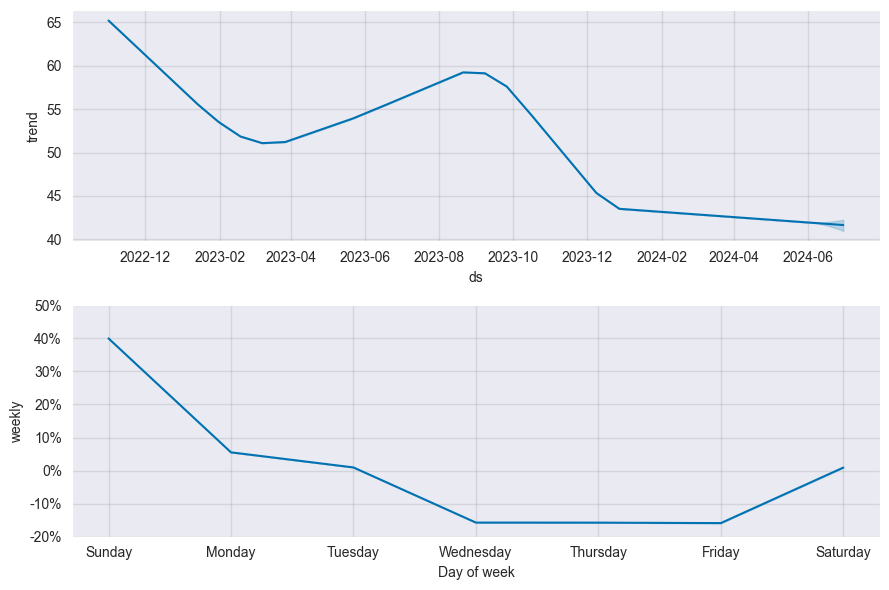

In [59]:
fig = m.plot_components(forecast)

National holidays can also be added

In [31]:
# m = Prophet(holidays=promos)
# m.add_country_holidays(country_name='US')
# m.fit(df)

In [32]:
# forecast = m.predict(future)

In [33]:
# fig = m.plot_components(forecast)

In the documentation, there are also ways to use holidays for different regions

### Seasonalities

Seasonalities are made from partial Fourier sums, and while those estimates are usually appropriate, the periodic frequency can be modified
Custom seasonalities, seasonalities determined by irregular cycles, and prior scale for holidays and seasonality can also be adjusted

### Additional Regressors

We will add the regressor along with creating our final Prophet model. 

In [36]:
logger = logging.getLogger('cmdstanpy')
logger.setLevel(logging.ERROR)

In [37]:
m = Prophet(daily_seasonality ='auto', changepoint_prior_scale=.1, seasonality_mode= 'multiplicative', seasonality_prior_scale=.1, interval_width = 0.95, mcmc_samples=25000, uncertainty_samples = 2000).add_regressor('promos', standardize='False', mode='additive')
m.fit(df)

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [38]:
print(m.stan_fit.diagnose())

Processing csv files: C:\Users\norri\AppData\Local\Temp\tmpwv6uab9x\prophet_modelks8jk666\prophet_model-20240630150838_1.csv, C:\Users\norri\AppData\Local\Temp\tmpwv6uab9x\prophet_modelks8jk666\prophet_model-20240630150838_2.csv, C:\Users\norri\AppData\Local\Temp\tmpwv6uab9x\prophet_modelks8jk666\prophet_model-20240630150838_3.csv, C:\Users\norri\AppData\Local\Temp\tmpwv6uab9x\prophet_modelks8jk666\prophet_model-20240630150838_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [39]:
# fit_summary = m.stan_fit.summary()

In [57]:
future = m.make_future_dataframe(periods=30)
future['promos'] = df['promos']
future = future.fillna(0)

?Should filling promos with 0 be done

In [41]:
# future = m.make_future_dataframe(periods=30)
# future['promos'] = future['ds'].apply(promos)
# forecast = m.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

In [58]:
forecast = m.predict(future)
# fig = m.plot_components(forecast)

Added regressor does not have to be binary. Optional arguments for setting prior and stardardization
the added regressor must be know for the observed and future values associated in the simpler model

The beta coefficients can be pulled, and if MCMC samples is specified, a credible interval can be determined for each coefficient, which can tell us is that regressor is meaningful

In [45]:
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,promos,additive,0.005329,-7.18838,23.422538,53.992807


### Multiplicative seasonality, while not useful for the data currently being used, is documented 

### Uncertainty

Sets width of uncertainty intervals

Seasonality uncertainty

In [ ]:
# forecast = m.fit(df, show_progress=True).predict(future)

In [ ]:
# fig = m.plot_components(forecast)

This section sets all the parameters for the Prophet model. Setting the growth as linear for now, but worth experimenting with. Changepoints are locations where the rate of change is potentially allowed to change.
The yearly, weekly, and daily seasonality are set here as auto for yearly and weekly, so Prophet can detect it, and daily for false, so it doesn't detect any false readings. Seasonality mode is defined to as either additive or multiplicative for better fitting.
The following parameters are set to avoid overfitting. Note that at the end of the notebook there is a bit that runs a check on the priors.
Fit should be set to false to add extra regressors.

In [ ]:
# m = Prophet(growth = 'linear',
#             n_changepoints = 25,
#             changepoint_range = 0.8,
#             # what to set seasonality to with daily data?
#             yearly_seasonality = 'auto',
#             weekly_seasonality = 'auto',
#             daily_seasonality = 'auto',
#             holidays = promos,
#             # how to determine additive or multiplicative
#             seasonality_mode = 'additive',
#             # best method of adjusting priors and setting mcmc values
#             seasonality_prior_scale = 10.0,
#             holidays_prior_scale = 10.0,
#             changepoint_prior_scale = 0.05,
#             mcmc_samples = 800,
#             interval_width = 0.20,
#             uncertainty_samples = 500)
#             # stan_backend = 'False')
#             # fit = False)


## ProphetModel Diagnostics

In [ ]:
fig1 = m.plot(forecast)

In [ ]:
fig2 = m.plot_components(forecast)

The cross_validation function here uses historical data to measure forecast error. The next function prints off the different measures it uses, like RMSE, SMAPE, etc.

In [47]:
from distributed import Client, performance_report

client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 63.91 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52803,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 63.91 GiB
Comm: tcp://127.0.0.1:52871,Total threads: 1
Dashboard: http://127.0.0.1:52876/status,Memory: 3.99 GiB
Nanny: tcp://127.0.0.1:52806,


In [48]:
df_cv = cross_validation(m, horizon='30 days', parallel='dask')

In [49]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,850.446494,29.162416,22.511189,0.826787,0.373983,0.468277,0.955556
1,5 days,823.425673,28.695395,22.518975,0.832807,0.373554,0.469534,0.955914
2,6 days,923.326987,30.386296,24.046083,0.811376,0.383446,0.479554,0.932975
3,7 days,662485.179761,813.931926,108.962756,2.100634,0.458418,0.519857,0.932963
4,8 days,662443.701578,813.906445,108.157954,2.085099,0.403357,0.503874,0.932593


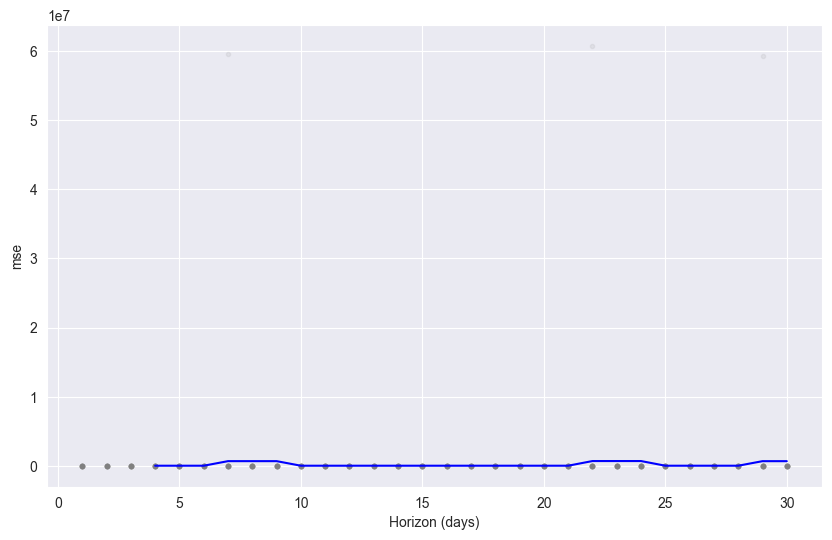

In [54]:
fig = plot_cross_validation_metric(df_cv, metric='mse')

In [55]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, horizon = '30', parallel='dask')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
5                     0.001                     1.00   multiplicative   
6                     0.001                    10.00         additive   
7                     0.001                    10.00   multiplicative   
8                     0.010                     0.01         additive   
9                     0.010                     0.01   multiplicative   
10                    0.010                     0.10         additive   
11                    0.010                     0.10   multiplicative   
12                    0.010                     1.0

In [56]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


This plots the difference between the forecast and the actuals.

In [ ]:
plt.plot(forecast['forecast'], label='Forecast')
plt.plot(df['y'], label='Actuals')
leg = plt.legend()
plt.show()
df_p = performance_metrics(df_cv)
df_p.head()

Similar metrics to those from the cross_validation function could be used to compare the historical error to the model error.

In [ ]:
## Estimating the statistical distributions of each variable and fitting them to their original shape

In [ ]:
# from prophet.plot import plot_cross_validation_metric
# fig = plot_cross_validation_metric(df_cv, metric='mape')